In [64]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from scipy.stats import gaussian_kde

# for dark-mode
COLOR = 'white'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

# more readable font size?
matplotlib.rcParams.update({'font.size': 18})

In [49]:
dataset_path = Path("../synth_crptn+shift/150")

dataset_csv = {'train': dataset_path / "train.csv",
              'val': dataset_path / "val.csv",
              'test': dataset_path / "test.csv"}

df = {key: pd.read_csv(value) for key, value in dataset_csv.items()}
[(len(value)) for key, value in df.items()]

[627682, 155520, 194400]

In [8]:
x = 20
y = 20
matplotlib.rcParams['figure.figsize'] = [x*1.5, y*1.5]


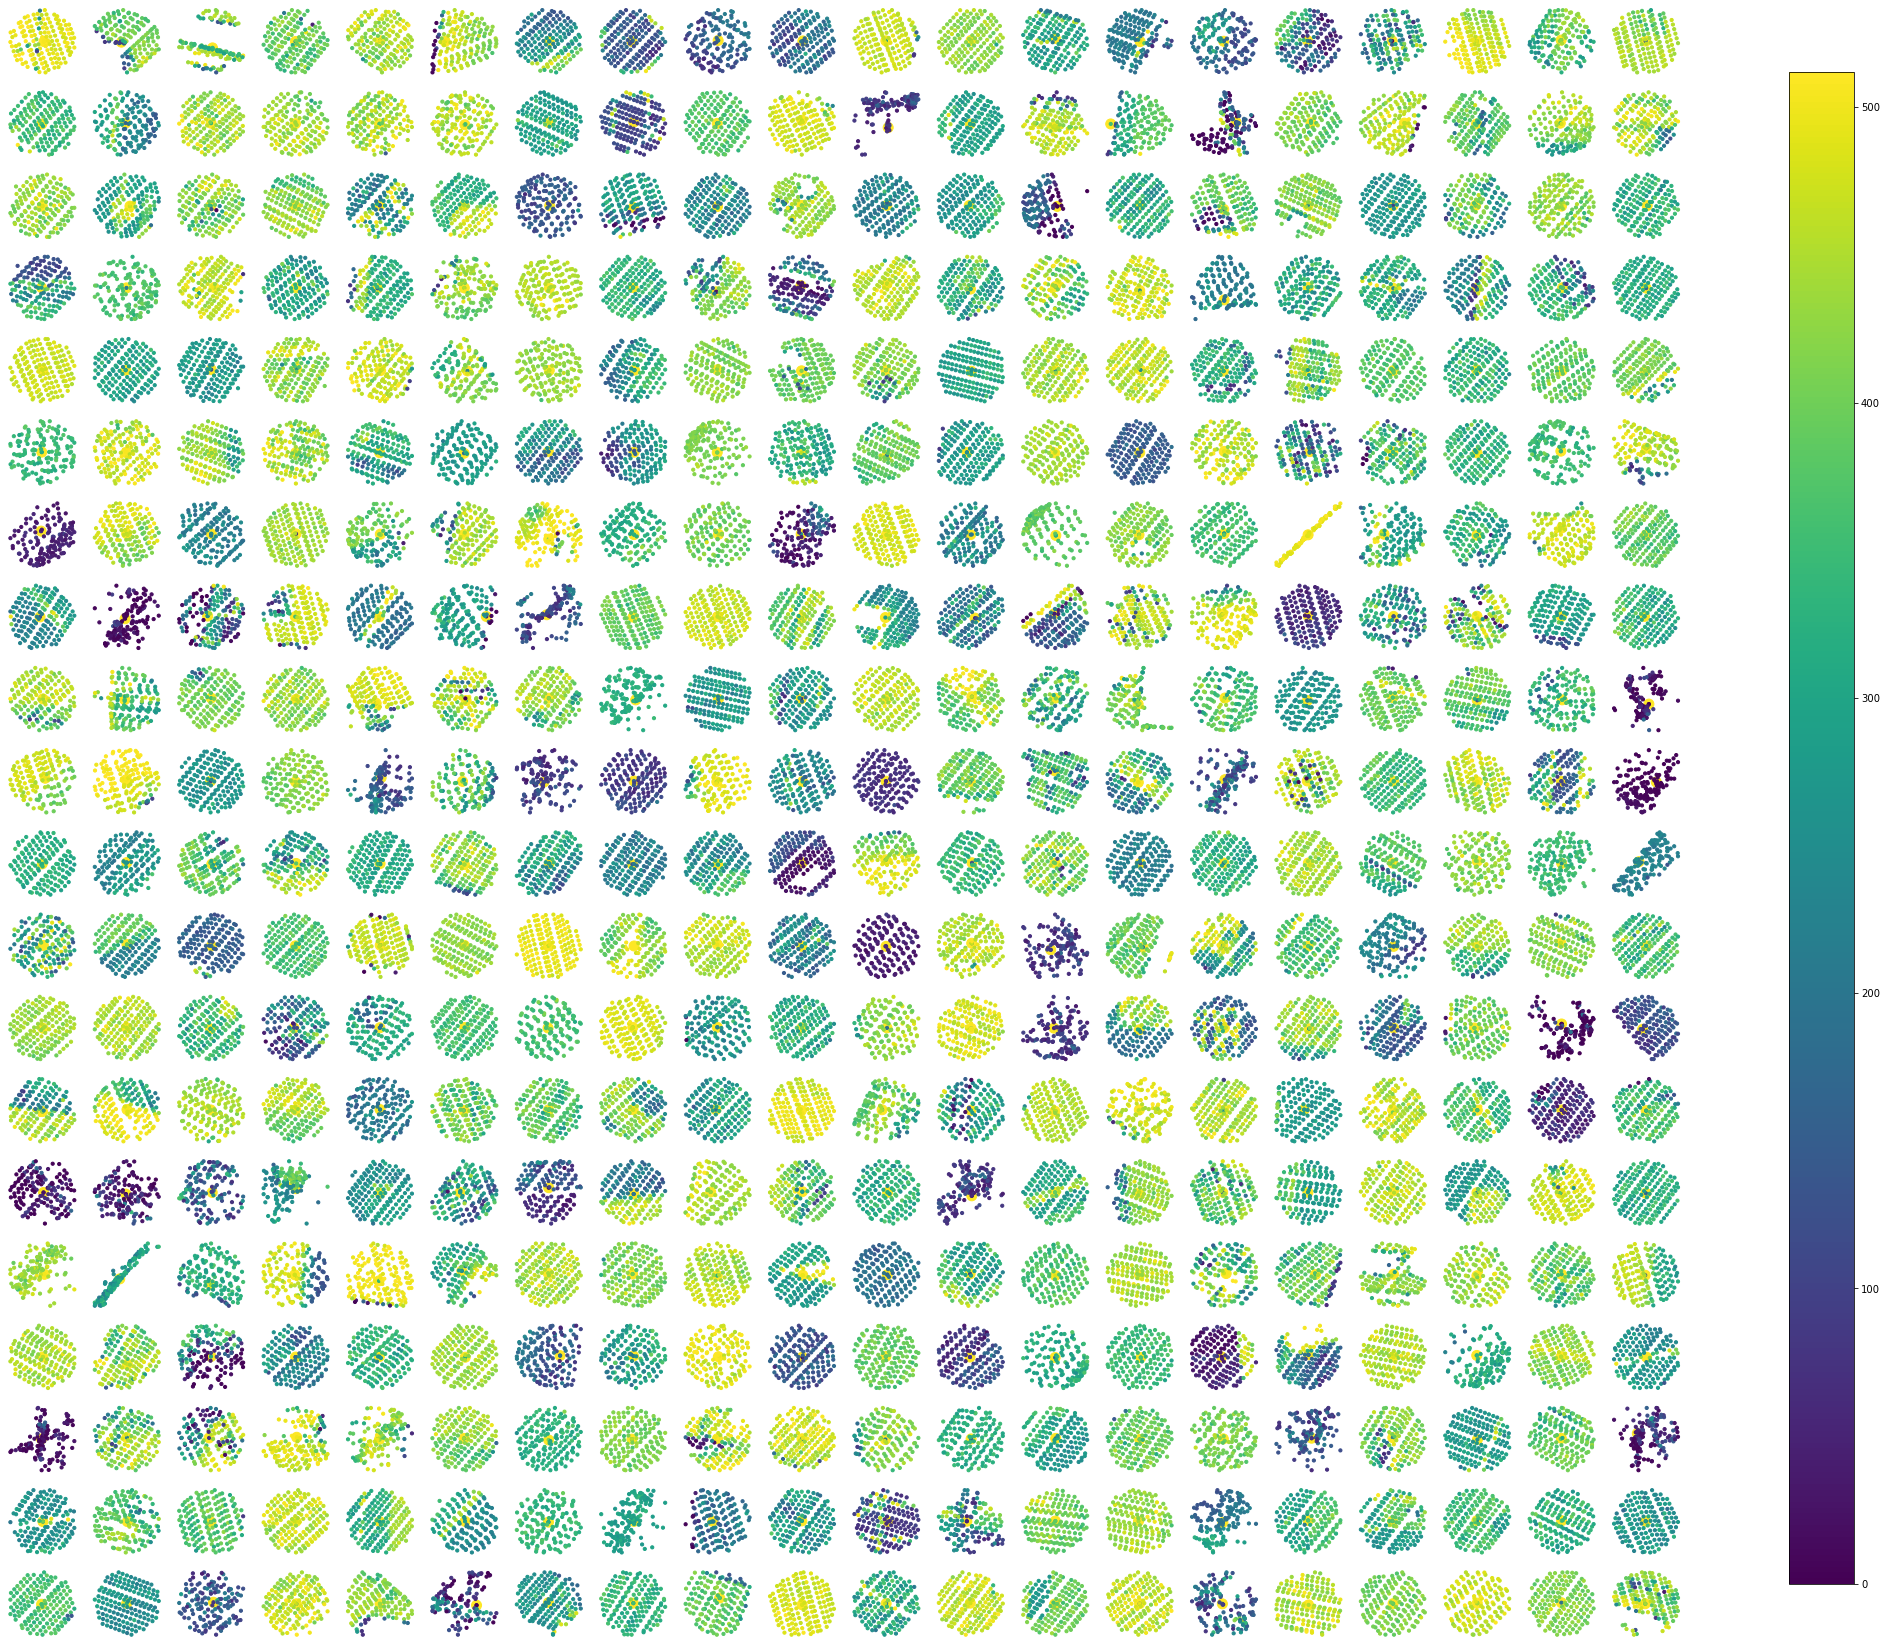

In [9]:
# Visualize Intenties
sample = np.random.choice(len(df['train']), (x, y))
fig, ax = plt.subplots(y, x)
for i in range(y):
    for j in range(x):
        example = np.loadtxt(df['train'].iloc[sample[j, i]][1])
        # Adjust the gt-center to be more visible
        center = np.ones((example.shape[0])) * 10
        center[0] = 100
        intensity = example[:, 3]
        intensity[0] = 512
        s = ax[i][j].scatter(example[:, 0], example[:, 1], s=center, c=example[:, 3], vmin=0, vmax=512)
        ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()

Total examples train:  486180
Total examples val:  182811
Total examples test:  228514


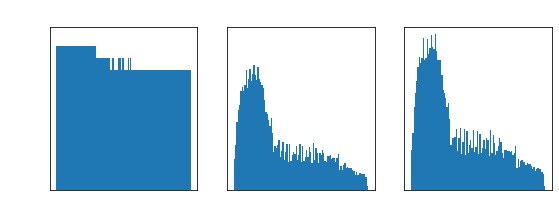

In [74]:
# Distribution of Intensities in the csv
dataset_path = Path("../synth_crptn+shift/150")

dataset_csv = {'train': dataset_path / "train.csv",
              'val': dataset_path / "val.csv",
              'test': dataset_path / "test.csv"}

bin_size = 5
bin_edges = [(i, i+bin_size) for i in range(0, 512, bin_size)]

df = {key: pd.read_csv(value) for key, value in dataset_csv.items()}
matplotlib.rcParams['figure.figsize'] = [9, 3]
matplotlib.rcParams.update({'font.size': 14})
intensities = {}

for key, value in df.items():
    curr_df = df[key]    
    # Use Target intensity column
    intensities[key] = curr_df.target_intensity
    intensities[key] = np.array(intensities[key])
        
    intensities[key] = intensities[key].flatten()
    print(f"Total examples {key}: ", intensities[key].shape[0])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(intensities['train'], [i[1] for i in bin_edges])
ax1.set_title("Train")
ax2.hist(intensities['val'], [i[1] for i in bin_edges])
ax2.set_title("Validation")
ax3.hist(intensities['test'], [i[1] for i in bin_edges])
ax3.set_title("Testing")
plt.show()

train
(627682,)
val
(155520,)
test
(194400,)


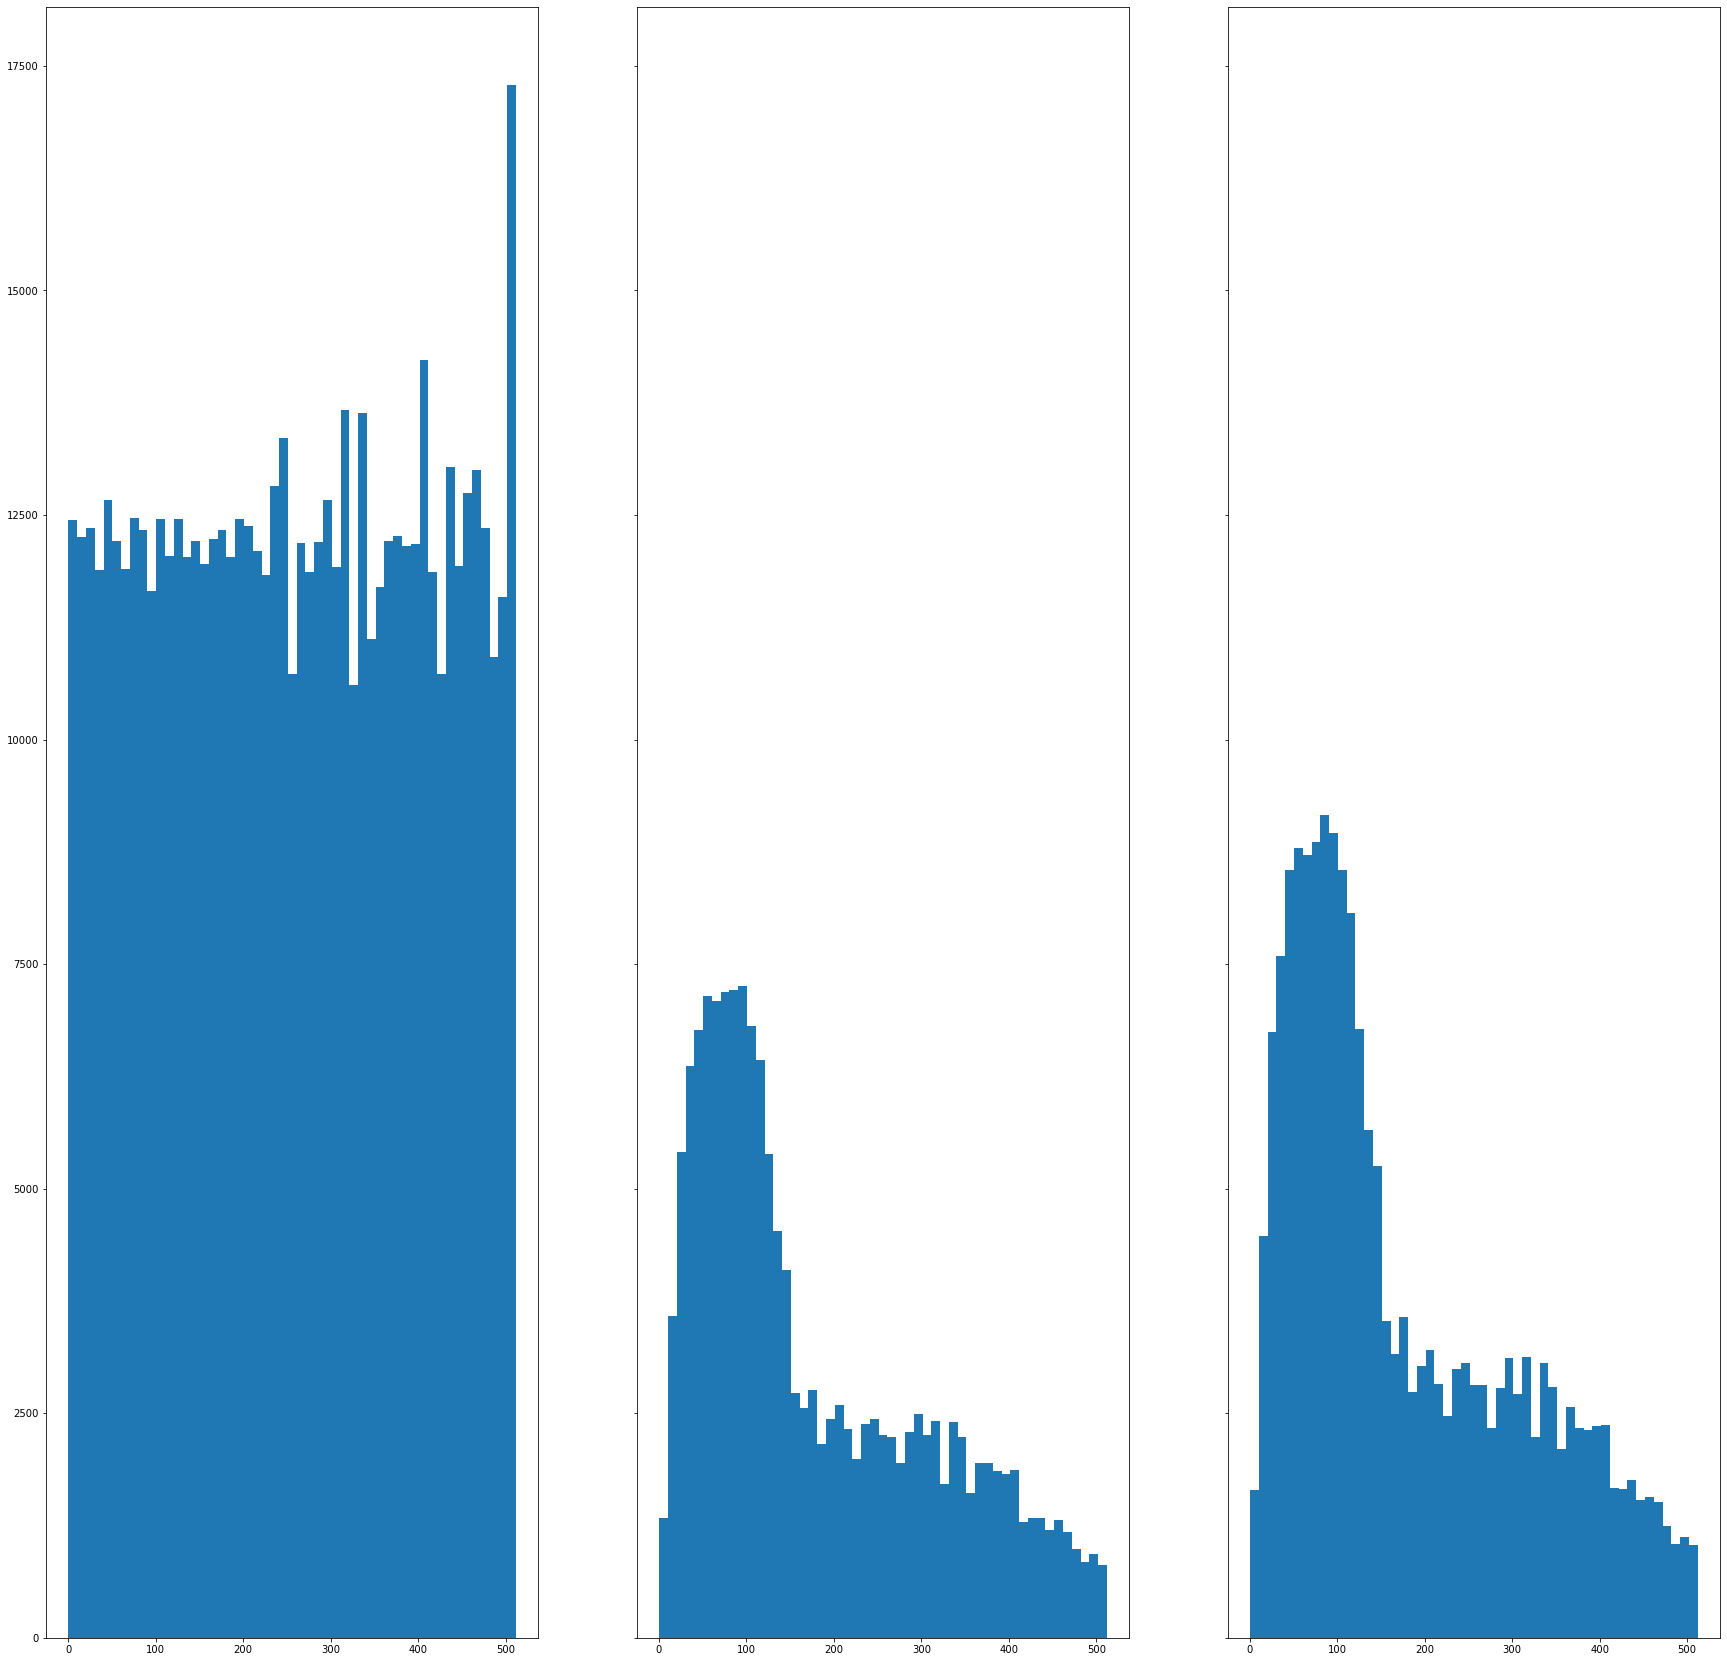

In [51]:
# Distribution of target intensities in the files themselves
# Slow!! Don't run unless there is a need to
intensities = {}
matplotlib.rcParams['figure.figsize'] = [9, 3]

for key, value in df.items():
    print(key)
    curr_df = df[key]
    intensities[key] = []
    # Load examples
    for i in range(len(curr_df)):
        ex = np.loadtxt(curr_df.iloc[i][1])
        intensities[key].append(ex[0, 3])
    
    intensities[key] = np.array(intensities[key])
    intensities[key] = intensities[key].flatten()
    print(intensities[key].shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
ax1.hist(intensities['train'], [i[1] for i in bin_edges])
ax1.set_title("Train")
ax2.hist(intensities['val'], [i[1] for i in bin_edges])
ax2.set_title("Validation")
ax3.hist(intensities['test'], [i[1] for i in bin_edges])
ax3.set_title("Testing")
plt.show()

In [47]:
# If the plots from the above two cells do not line up, there was an issue 
#     during dataset creation. The balance of intensities must be correct, 
#     otherwise there will be issues during training. 

#     This cell fixes one possible source of error by renaming every file in master.csv
#         to the correct name (whatever target intensity is found in each file).
#         After running this cell, running make_csv again will create the 
#         correct balance
# 
from os import rename
save_format = "{source_scan}_{target_scan}_{center}_{idx}.txt.gz"

master = dataset_path / "master.csv"
neighborhoods = dataset_path / "neighborhoods"
df = pd.read_csv(master)
test = False; goto = 20
for i in range(len(df)):
    
    row = df.iloc[i]
    ex = np.loadtxt(row['examples'])
    actual_intensity = ex[0, 3]
    df_intensity = row['target_intensity']
    target_scan = row['target_scan']
    source_scan = row['source_scan']
    idx = row['examples'].split('_')[-1].split(".")[0]
    
    old = row['examples']
    save_string = save_format.format(
        source_scan=source_scan,
        target_scan=target_scan,
        center=str(int(actual_intensity)),
        idx=idx
    )
    new = (neighborhoods / save_string).resolve()
    
    if test:
        if i < goto:
            # old = row['examples'].split("/")[-1]
            print(f"Example: {old} ==> {new}, {df_intensity} ==> {int(actual_intensity)}")
        else:
            break
    
    if not test:
        rename(str(neighborhoods / old), str(neighborhoods / new))
        
    

In [ ]:
# Visualize Scan Angle Rank 
fig, ax = plt.subplots(y, x)

# Scan Angle Rank Ranges by dataset:
# train: 32.0, -14.0
# val: 3, -18
# test: 26, 22 
# hmm...

for i in range(y):
    for j in range(x):
        example = np.load(df['train'].iloc[sample[j, i]][1])
        # Adjust the "center" to be more visible
        s = ax[i][j].scatter(example[:, 0], example[:, 1], s=10, c=abs(example[:, 4]), vmin=0, vmax=32)
        ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()

# The middle point will be different since it comes from a different scan!

In [ ]:
# Visualize Flight Number 
fig, ax = plt.subplots(y, x)

# Scan Angle Rank Ranges by dataset:
# train: 32.0, -14.0
# val: 3, -18
# test: 26, 22 
# hmm...

for i in range(y):
    for j in range(x):
        example = np.load(df['train'].iloc[sample[j, i]][1])
        # Adjust the "center" to be more visible
        s = ax[i][j].scatter(example[:, 0], example[:, 1], s=10, c=abs(example[:, 8]), vmin=0, vmax=41)
        ax[i][j].axis('off')

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()

# The middle point will be different since it comes from a different scan!

In [ ]:
# Balancing Examples by Flight Number (undersampled)
my_bins = df['train'].flight_num.unique()
my_bins.sort()
my_bins = np.concatenate((my_bins, np.array([40])))
my_bins = np.arange(41)
print(my_bins)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(df['train'].flight_num.values, my_bins)
ax2.hist(df['val'].flight_num.values, my_bins)
ax3.hist(df['test'].flight_num.values, my_bins)
plt.show()

In [ ]:
# Plots:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
my_bins2 = [i for i in range(0, 520, 10)]
print(my_bins)
print(my_bins2)
ax1.hist2d(scan_angle['train'], intensities['train'], bins=[my_bins, my_bins2])
ax2.hist2d(scan_angle['val'], intensities['val'], bins=[my_bins, my_bins2])
ax3.hist2d(scan_angle['test'], intensities['test'], bins=[my_bins, my_bins2])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
fig.colorbar(s, cax=cbar_ax)

plt.show()